<a href="https://colab.research.google.com/github/prtk0007/Chest_Xray_detection/blob/exp_binary/Project_ray_7_Inception_acc_90_70_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [2]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:33<00:00, 27.5MB/s]
100% 2.29G/2.29G [00:33<00:00, 73.6MB/s]


In [3]:
!unzip \*.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [4]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
#from keras.applications.resnet50 import ResNet50
#from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [5]:
incept3=InceptionV3(input_shape=(180,180,3),
                             include_top=False,
                             weights='imagenet')
#freazing the trained layers
for layers in incept3.layers:
    layers.trainable=False

87916544/87910968 [==============================] - 1s 0us/step


In [6]:
incept3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 89, 89, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 89, 89, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 89, 89, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [7]:
last_layer=incept3.get_layer('mixed10')
last_output = last_layer.output

In [8]:
from keras.layers import Dropout
x=Flatten()(last_output)
x=Dense(1024,activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(256,activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(1,activation='sigmoid')(x)

model3=Model(incept3.input,x)
from keras.optimizers import Adam
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
               metrics=['accuracy'])
# model4.summary()

In [9]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 89, 89, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 89, 89, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 89, 89, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255) 
val_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
training_set = train_datagen.flow_from_directory('/content/chest_xray/chest_xray/train',
                                                 target_size = (180, 180),
                                                 batch_size = 128,
                                                 class_mode = 'binary')

Found 5216 images belonging to 2 classes.


In [12]:
test_set = test_datagen.flow_from_directory('/content/chest_xray/chest_xray/test',
                                            target_size = (180, 180),
                                            batch_size = 128,
                                            shuffle=False,
                                            class_mode = 'binary')

Found 624 images belonging to 2 classes.


In [17]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
early = EarlyStopping(monitor='val_loss', mode='min', patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience =  8 , verbose=1,factor=0.2, min_lr=0.00001)
callbacks_list = [ early, learning_rate_reduction]

In [18]:
r3=model3.fit(training_set,validation_data=test_set,epochs=30,verbose=2,callbacks=callbacks_list)

Epoch 1/30
41/41 - 83s - loss: 0.1463 - accuracy: 0.9429 - val_loss: 0.3062 - val_accuracy: 0.8878
Epoch 2/30
41/41 - 81s - loss: 0.1424 - accuracy: 0.9490 - val_loss: 0.2806 - val_accuracy: 0.8958
Epoch 3/30
41/41 - 81s - loss: 0.1266 - accuracy: 0.9528 - val_loss: 0.4687 - val_accuracy: 0.8622
Epoch 4/30
41/41 - 81s - loss: 0.1338 - accuracy: 0.9482 - val_loss: 0.3402 - val_accuracy: 0.8878
Epoch 5/30
41/41 - 81s - loss: 0.1243 - accuracy: 0.9549 - val_loss: 0.3056 - val_accuracy: 0.8974
Epoch 6/30
41/41 - 82s - loss: 0.1269 - accuracy: 0.9511 - val_loss: 0.3015 - val_accuracy: 0.8942
Epoch 7/30
41/41 - 81s - loss: 0.1225 - accuracy: 0.9557 - val_loss: 0.2887 - val_accuracy: 0.8910
Epoch 8/30
41/41 - 81s - loss: 0.1113 - accuracy: 0.9597 - val_loss: 0.3107 - val_accuracy: 0.9054
Epoch 9/30
41/41 - 82s - loss: 0.1092 - accuracy: 0.9597 - val_loss: 0.2634 - val_accuracy: 0.8990
Epoch 10/30
41/41 - 83s - loss: 0.1101 - accuracy: 0.9572 - val_loss: 0.3757 - val_accuracy: 0.9054
Epoch 11/

In [21]:
model3.evaluate(test_set)

5/5 [==============================] - 5s 772ms/step - loss: 0.3317 - accuracy: 0.9054


[0.33166366815567017, 0.9054487347602844]

In [ ]:
cd /content/drive/MyDrive/Kaggle

/content/drive/MyDrive/Kaggle


chest_xray		  drive		    kaggle.json
chest-xray-pneumonia.zip  Inceptv3_xray.h5  sample_data


In [ ]:
model3.save('Inceptv3_xray.h5')

In [ ]:
from keras.models import load_model

In [ ]:
model3 = load_model('/content/drive/MyDrive/Kaggle/Inceptv3_xray.h5')

In [ ]:
eval_result3 = model3.evaluate_generator(test_set, 624)
print('loss  :', eval_result3[0])
print('accuracy  :', eval_result3[1])
print('Precision :', eval_result3[2])
print('Recall :', eval_result3[3])


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


loss  : 0.2906516194343567
accuracy  : 0.9070512652397156
Precision : 0.9070512652397156
Recall : 0.9070512652397156


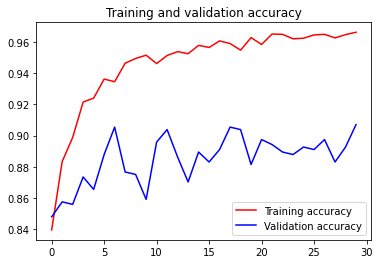

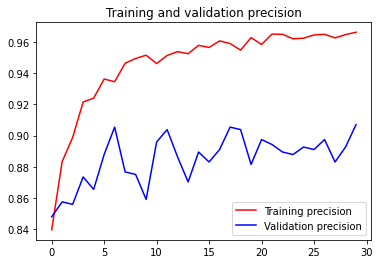

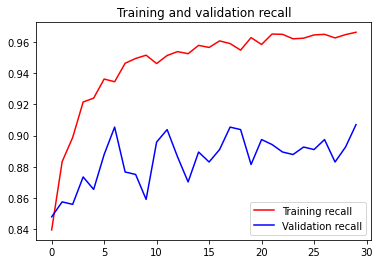

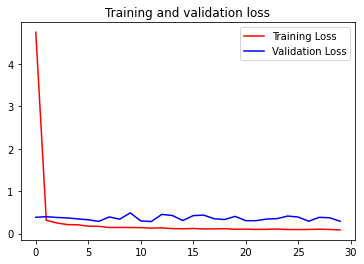

In [ ]:
acc3 = r3.history['accuracy']
val_acc3 = r3.history['val_accuracy']

train_precision3=r3.history['precision']
val_precision3=r3.history['val_precision']

train_recall3=r3.history['recall']
val_recall3=r3.history['val_recall']

loss3 = r3.history['loss']
val_loss3 = r3.history['val_loss']
epochs = range(len(acc3))

plt.plot(epochs, acc3, 'r', label='Training accuracy')
plt.plot(epochs, val_acc3, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, train_precision3, 'r', label='Training precision')
plt.plot(epochs, val_precision3, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.show()

plt.plot(epochs, train_recall3, 'r', label='Training recall')
plt.plot(epochs, val_recall3, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.show()

plt.plot(epochs, loss3, 'r', label='Training Loss')
plt.plot(epochs, val_loss3, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
from keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.resnet50 import ResNet50
#from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
TRAIN_DIR = "/content/chest_xray/chest_xray/train/"
TEST_DIR =  "/content/chest_xray/chest_xray/test/"

In [ ]:
def get_label(Dir):
    for nextdir in os.listdir(Dir):
        if not nextdir.startswith('.'):
            if nextdir in ['NORMAL']:
                label = 0
            elif nextdir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
    return nextdir, label

In [ ]:
def preprocessing_data(Dir):
    X = []
    y = []
    
    for nextdir in os.listdir(Dir):
        nextdir, label = get_label(Dir)
        temp = Dir + nextdir
        
        for image_filename in tqdm(os.listdir(temp)):
            path = os.path.join(temp + '/' , image_filename)
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = skimage.transform.resize(img, (180, 180, 3))
                img = np.asarray(img)
                X.append(img)
                y.append(label)
            
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y

In [ ]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['NORMAL']:
                label = 0
            elif nextDir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                
            temp = Dir + nextDir
                
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (180, 180, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(150, 150, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [ ]:
X_test , y_test = get_data(TEST_DIR)

100%|██████████| 234/234 [01:39<00:00,  2.35it/s]


In [ ]:
from keras.utils.np_utils import to_categorical
y_test = to_categorical(y_test)


In [ ]:
y_test[5]

array([0., 1.], dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix
pred = model3.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

In [ ]:
y_true

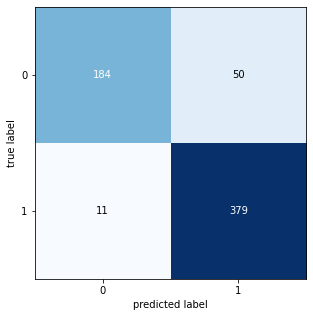

In [ ]:
cm = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))
plt.show()

In [ ]:
print('True Positive  (TP) = ', cm[1][1])
print('False Positive (FP) = ', cm[0][1])
print('False Negative (FN) = ', cm[1][0])
print('True Negative  (TN) = ', cm[0][0])
print('-'*26)

True Positive  (TP) =  379
False Positive (FP) =  50
False Negative (FN) =  11
True Negative  (TN) =  184
--------------------------


In [ ]:
if (cm[0][0] + cm[0][1])!=0 and (cm[0][0], cm[1][0])!=0:
      precision= round((cm[0][0] / (cm[0][0] + cm[0][1]))*100, 2) 
      recall   = round((cm[0][0] / (cm[0][0] + cm[1][0]))*100, 2) 
      f1_score = round(2*((precision*recall)/(precision+recall)), 2)       
      print(f'Precision Score: {precision}%')
      print(f'Recall Score: {recall}%')
      print(f'F1 Score: {f1_score}%')
      print('='*50) 
      print('\n')

Actual class: PNEUMONIA
Predicted class: Pneumonia


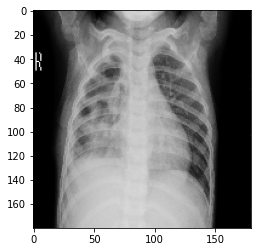

In [ ]:
import random
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

def choose_image_and_predict():
    normal_or_pneumonia = ['NORMAL', 'PNEUMONIA']
    folder_choice = (random.choice(normal_or_pneumonia))
    
    pneumonia_images = glob('/content/chest_xray/chest_xray/val/'+folder_choice+'/*')
    img_choice = (random.choice(pneumonia_images))

    img = load_img(img_choice, target_size=(180, 180))
    img = img_to_array(img)
    plt.imshow(img / 255.)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    pred = model3.predict(x)
    pred_class = pred.argmax(axis=-1)
    print("Actual class:", folder_choice)
    if pred_class[0] == 0:
        print("Predicted class: Normal")
    else:
        print("Predicted class: Pneumonia")
               
        
choose_image_and_predict()

Predicted class: Pneumonia


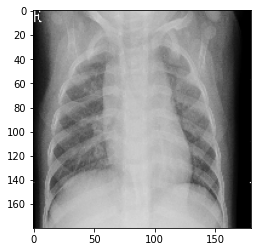

In [ ]:
img = image.load_img('/content/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg', target_size=(180,180))
plt.imshow(img)
x=image.img_to_array(img)
x=np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model3.predict(img_data)
if classes[0][0] > 0.8:
        print("Predicted class: Normal")
else:
        print("Predicted class: Pneumonia")

0.023549343